# EN4 RAPID-OSNAP into T/S space

In [1]:
# import sys
# sys.path.append('/Users/dge105/Dropbox/Python_modules')

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates
import matplotlib
import datetime
import numpy as np
import cmocean
import pickle
import gsw
import seawater as sw
import numpy_groupies as npg
import cartopy.crs as ccrs
import os

from wmt import bin_3D_field_2D
from wmt import calc_tot_trans
from wmt import calc_grid_vol

from sklearn import preprocessing
from sklearn import mixture

from matplotlib import gridspec 

In [2]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

### Load RG Argo data
Data extracted and saved within ~/Dropbox/work_general/datasets/RG_Argo/RG_Argo_extract.ipynb

In [3]:
lon_limits = [275, 355]
lat_limits = [25, 60]

dset_dir = os.path.expanduser('~/Dropbox/work_general/datasets/EN4/*.nc')
dset = xr.open_mfdataset(dset_dir)
# dset = dset.sel(lon=((dset.lon<20) | (dset.lon>275)), lat=slice(lat_limits[0],lat_limits[1]))
dset = dset.sel(lon=((dset.lon>275) & (dset.lon<355)), lat=slice(lat_limits[0],lat_limits[1]))

m_dats = mdates.date2num(dset.time)

In [4]:
# Load basin mask
# mask_dir = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods'
# mask = xr.open_dataset(mask_dir)

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


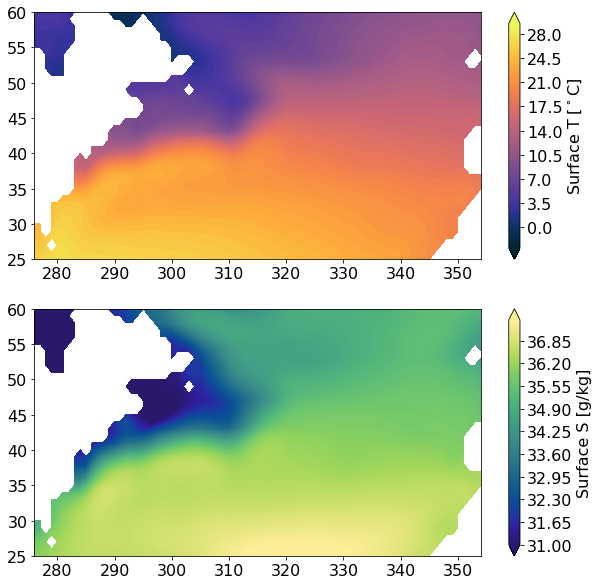

In [4]:
fig = plt.figure(figsize=(10,10))
ax1, ax2 = fig.subplots(2,1)

T_levels = np.arange(-3, 30, 0.5) 
S_levels = np.arange(31, 37.5, 0.05) 

CS_T = ax1.contourf(dset.lon, dset.lat, np.nanmean(dset.temperature[:, 0, :, :], axis=0) - 273.15,
           T_levels, cmap=cmocean.cm.thermal, extend='both')

CS_S = ax2.contourf(dset.lon, dset.lat, np.nanmean(dset.salinity[:, 0, :, :], axis=0),
           S_levels, cmap=cmocean.cm.haline, extend='both')

cbarT = fig.colorbar(CS_T, ax=ax1)
cbarT.ax.set_ylabel('Surface T [$^\circ$C]')

cbarS = fig.colorbar(CS_S, ax=ax2)
cbarS.ax.set_ylabel('Surface S [g/kg]')

plt.savefig(os.path.expanduser('~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/EN4_RAPID2OSNAP_surfTS.png'), dpi=300, bbox_inches='tight')


In [5]:
lat = dset.lat.data
lon = dset.lon.data
dep = dset.depth.data
max_dep = dep[-1] + np.diff(dep)[-1]

gr_vol = calc_grid_vol(lon, lat, dep, 'm', 0, max_dep)

In [6]:
lon_g, lat_g = np.meshgrid(lon, lat)

lon_g = np.moveaxis(np.repeat(np.expand_dims(lon_g, axis=2), len(dep), axis=2), [2], [0])
lat_g = np.moveaxis(np.repeat(np.expand_dims(lat_g, axis=2), len(dep), axis=2), [2], [0])
dep_g = np.moveaxis(np.tile(dep, (np.shape(lat_g)[2], np.shape(lat_g)[1], 1)), [0, 1, 2], [2, 1, 0])


### Loop through each time-step

In [7]:
dS = 0.025
dT = 0.25
# S_bin = np.arange(32, 38 + dS, dS)
S_bin = np.arange(25, 40 + dS, dS)
T_bin = np.arange(-3, 32 + dT, dT)
S_bini = S_bin[0:-1] + dS/2
T_bini = T_bin[0:-1] + dT/2 
S_binii = S_bini[0:-1] + dS/2
T_binii = T_bini[0:-1] + dT/2 

In [8]:
lon_g, lat_g = np.meshgrid(dset.lon, dset.lat)
lon_g = np.repeat(np.expand_dims(lon_g, axis=0), len(dset.depth), axis=0)
lat_g = np.repeat(np.expand_dims(lat_g, axis=0), len(dset.depth), axis=0)
pres_g = np.moveaxis(np.tile(dset.depth, (np.shape(lon_g)[2], np.shape(lon_g)[1], 1)), [0, 1, 2], [2, 1, 0])

ts_vol = np.zeros((len(T_bini), len(S_bini), np.shape(dset.temperature)[0]))
ts_lat = np.zeros((len(T_bini), len(S_bini), np.shape(dset.temperature)[0]))
ts_lon = np.zeros((len(T_bini), len(S_bini), np.shape(dset.temperature)[0]))
ts_dep = np.zeros((len(T_bini), len(S_bini), np.shape(dset.temperature)[0]))

bin_edge1 = T_bin
bin_edge2 = S_bin
# func = 'sum'

for ii in np.arange(0, np.shape(dset.temperature)[0], 1):

    SA = gsw.SA_from_SP(dset.salinity[ii, :, :, :], pres_g, lon_g, lat_g)
    CT = gsw.CT_from_t(SA, dset.temperature[ii, :, :, :] - 273.15, pres_g)

    bin1_3D = CT
    bin2_3D = SA
    var_3D = gr_vol

    out = bin_3D_field_2D(var_3D, bin1_3D, bin2_3D, bin_edge1, bin_edge2, 'sum')
    ts_vol[:, :, ii] = out[0]
    
    var_3D = lon_g
    
    out = bin_3D_field_2D(var_3D, bin1_3D, bin2_3D, bin_edge1, bin_edge2, 'mean')
    ts_lon[:, :, ii] = out[0]

    var_3D = lat_g
    
    out = bin_3D_field_2D(var_3D, bin1_3D, bin2_3D, bin_edge1, bin_edge2, 'mean')
    ts_lat[:, :, ii] = out[0]
    
    var_3D = dep_g
    
    out = bin_3D_field_2D(var_3D, bin1_3D, bin2_3D, bin_edge1, bin_edge2, 'mean')
    ts_dep[:, :, ii] = out[0]
    
# ts_vol[ts_vol == 0] = np.nan
    
ts_vol = {'ts_vol': ts_vol, 'S_bini': S_bini, 'T_bini': T_bini, 'S_binii': S_binii, 'T_binii': T_binii, 'time': m_dats}
    

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


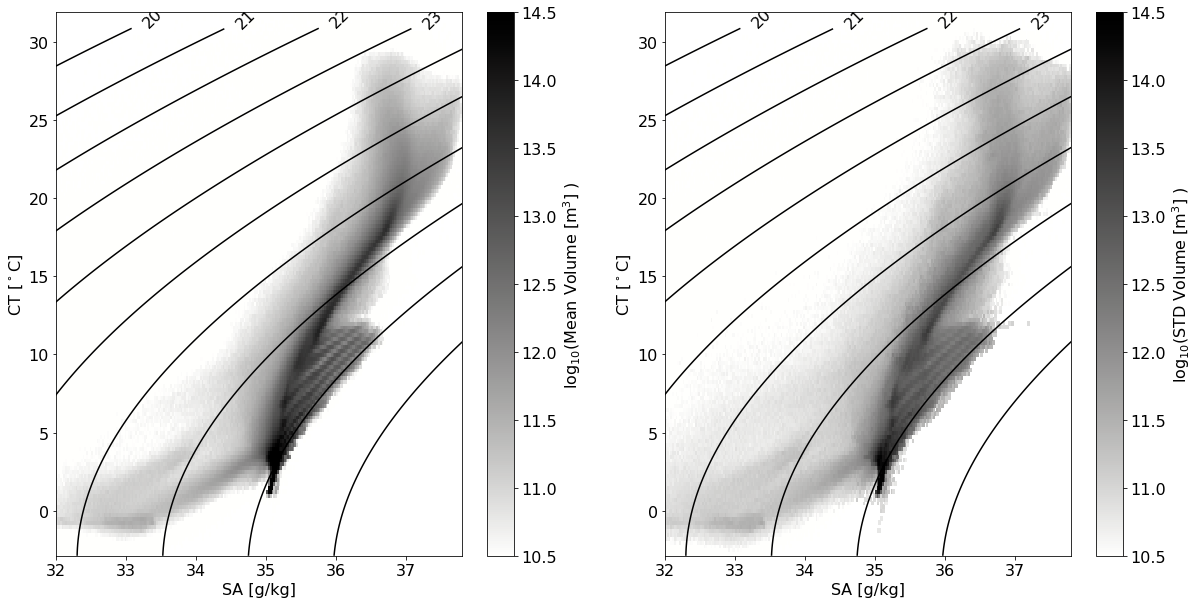

In [9]:
ts_vol_zero = ts_vol['ts_vol']
ts_vol_zero[np.isnan(ts_vol_zero)] = 0

S_g, T_g = np.meshgrid(S_bini, T_bini)
dens_g = sw.dens0(S_g,T_g) - 1000

c_lim = (10.5, 14.5)
levels = np.arange(c_lim[0], c_lim[1] + 0.1, 0.1)
fig = plt.figure(figsize=(20, 10))
ax1, ax2 = fig.subplots(1, 2)

CS1 = ax1.pcolormesh(S_bini, T_bini, np.log10(np.nanmean(ts_vol_zero, axis=2) ),  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
CS_dens = ax1.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax1.clabel(CS_dens, fmt='%2.0f')

CS2 = ax2.pcolormesh(S_bini, T_bini, np.log10(np.nanstd(ts_vol_zero, axis=2) ),  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
CS_dens = ax2.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax2.clabel(CS_dens, fmt='%2.0f')

cbar = fig.colorbar(CS1, ax=ax1)
cbar.ax.set_ylabel('log$_{10}$(Mean Volume [m$^3$] )')

cbar = fig.colorbar(CS2, ax=ax2)
cbar.ax.set_ylabel('log$_{10}$(STD Volume [m$^3$] )')

ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('CT [$^\circ$C]')

ax1.set_xlabel('SA [g/kg]')
ax2.set_xlabel('SA [g/kg]')

ax1.set_xlim((32, 37.8))
ax2.set_xlim((32, 37.8))

plt.savefig(os.path.expanduser('~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/EN4_RAPID2OSNAP_ts_vol_mean_std.png'), dpi=300, bbox_inches='tight')


In [12]:
from operator import add
from functools import reduce

def split4(image):
    half_split = np.array_split(image, 2)
    res = map(lambda x: np.array_split(x, 2, axis=1), half_split)
    return reduce(add, res)

def concatenate4(north_west, north_east, south_west, south_east):
    top = np.concatenate((north_west, north_east), axis=1)
    bottom = np.concatenate((south_west, south_east), axis=1)
    return np.concatenate((top, bottom), axis=0)


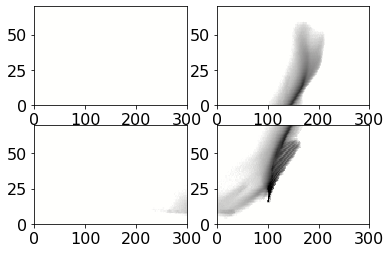

In [23]:
ts_vol_mean = np.nanmean(ts_vol_zero, axis=2)
img = np.zeros(np.shape(ts_vol_mean))
img[ts_vol_mean > 0] = np.log10(ts_vol_mean[ts_vol_mean > 0]) 

fig, ax = plt.subplots(2, 2)
ax[0, 0].pcolormesh(split_img[2], vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
ax[0, 1].pcolormesh(split_img[3], vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
ax[1, 0].pcolormesh(split_img[0], vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
ax[1, 1].pcolormesh(split_img[1], vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')

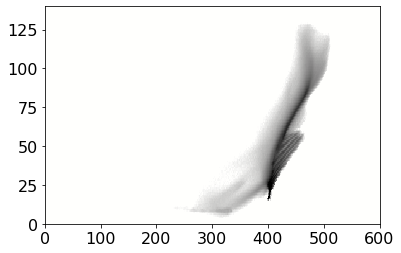

In [24]:
full_img = concatenate4(split_img[0], split_img[1], split_img[2], split_img[3])

fig, ax = plt.subplots()
ax.pcolormesh(full_img, vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')

[[6.09049333 4.69361871]
 [1.5512501  5.67035648]]
1.551250100262885
5.670356484399724
6.090493330807041
4.693618711783436


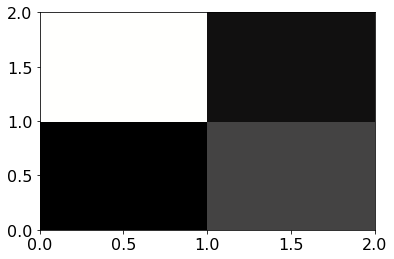

In [38]:
means = np.array(list(map(lambda x: np.mean(x), split_img))).reshape(2,2)

fig, ax = plt.subplots()
ax.pcolormesh(means, cmap=cmocean.cm.gray_r, shading='flat')

print(means)

print(np.mean(split_img[2]))
print(np.mean(split_img[3]))
print(np.mean(split_img[0]))
print(np.mean(split_img[1]))

In [39]:
def checkEqual(myList):
    first=myList[0]
    return all((x==first).all() for x in myList)

class QuadTree:
    
    def insert(self, img, level = 0):
        self.level = level
        self.mean = np.mean(img)
        self.resolution = (img.shape[0], img.shape[1])
        self.final = True
        
        if not checkEqual(img):
            split_img = split4(img)
            
            self.final = False
            self.north_west = QuadTree().insert(split_img[0], level + 1)
            self.north_east = QuadTree().insert(split_img[1], level + 1)
            self.south_west = QuadTree().insert(split_img[2], level + 1)
            self.south_east = QuadTree().insert(split_img[3], level + 1)

        return self
    
    def get_image(self, level):
        if(self.final or self.level == level):
            return np.tile(self.mean, (self.resolution[0], self.resolution[1], 1))
        
        return concatenate4(
            self.north_west.get_image(level), 
            self.north_east.get_image(level),
            self.south_west.get_image(level),
            self.south_east.get_image(level))

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


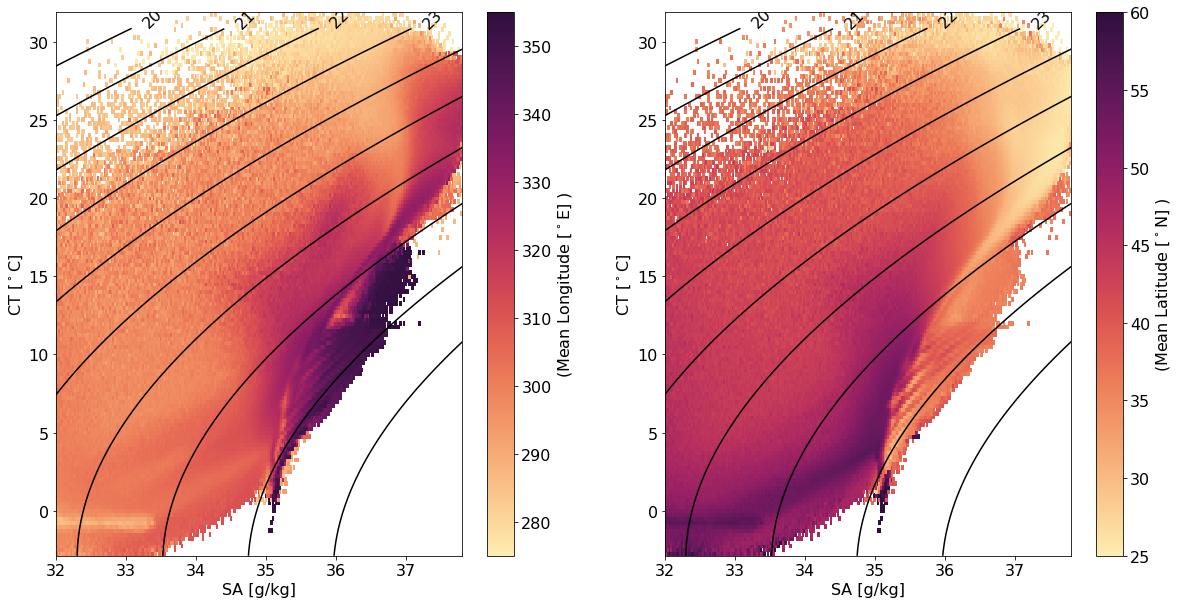

In [10]:
ts_vol_zero = ts_vol['ts_vol']
ts_vol_zero[np.isnan(ts_vol_zero)] = 0

S_g, T_g = np.meshgrid(S_bini, T_bini)
dens_g = sw.dens0(S_g,T_g) - 1000

levels = np.arange(c_lim[0], c_lim[1] + 0.1, 0.1)
fig = plt.figure(figsize=(20, 10))
ax1, ax2 = fig.subplots(1, 2)

CS1 = ax1.pcolormesh(S_bini, T_bini, (np.nanmean(ts_lon, axis=2) ),  vmin=lon_limits[0], vmax=lon_limits[1], cmap=cmocean.cm.matter, shading='flat')
CS_dens = ax1.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax1.clabel(CS_dens, fmt='%2.0f')

CS2 = ax2.pcolormesh(S_bini, T_bini, (np.nanmean(ts_lat, axis=2) ),  vmin=lat_limits[0], vmax=lat_limits[1], cmap=cmocean.cm.matter, shading='flat')
CS_dens = ax2.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax2.clabel(CS_dens, fmt='%2.0f')

cbar = fig.colorbar(CS1, ax=ax1)
cbar.ax.set_ylabel('(Mean Longitude [$^\circ$E] )')

cbar = fig.colorbar(CS2, ax=ax2)
cbar.ax.set_ylabel('(Mean Latitude [$^\circ$N] )')

ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('CT [$^\circ$C]')

ax1.set_xlabel('SA [g/kg]')
ax2.set_xlabel('SA [g/kg]')

ax1.set_xlim((32, 37.8))
ax2.set_xlim((32, 37.8))

plt.savefig(os.path.expanduser('~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/EN4_RAPID2OSNAP_ts_lon_lat.png'), dpi=300, bbox_inches='tight')


/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Text(0.5,0,'SA [g/kg]')

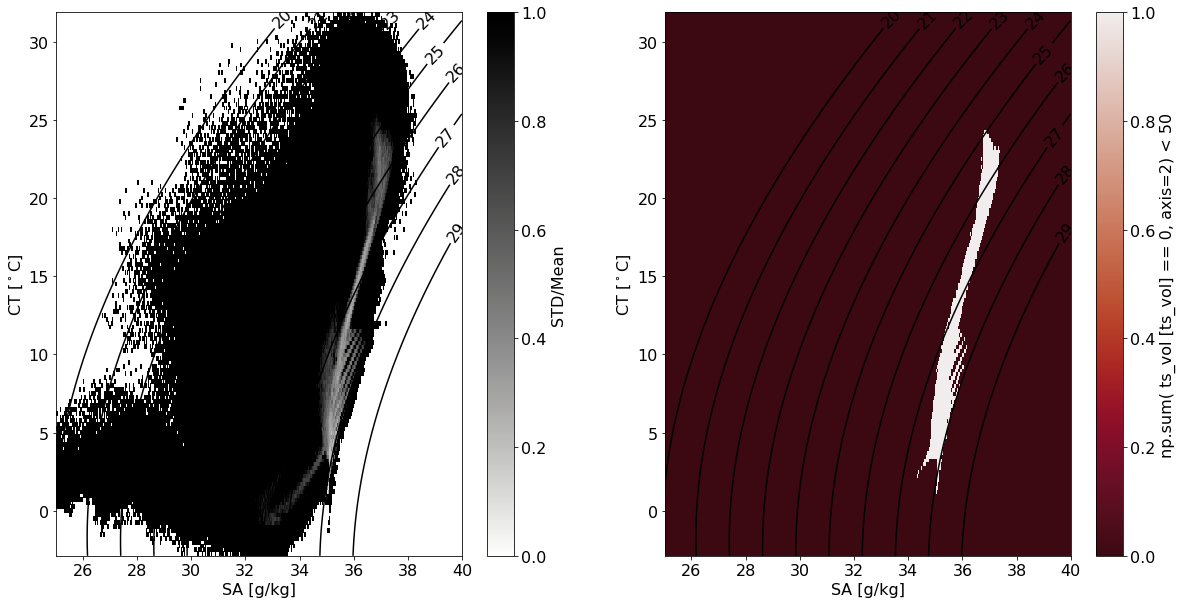

In [118]:
ts_vol_zero = ts_vol['ts_vol']
ts_vol_zero[np.isnan(ts_vol_zero)] = 0

S_g, T_g = np.meshgrid(S_bini, T_bini)
dens_g = sw.dens0(S_g,T_g) - 1000

c_lim = (0, 1)
levels = np.arange(c_lim[0], c_lim[1] + 0.1, 0.1)
fig = plt.figure(figsize=(20, 10))
ax1, ax2 = fig.subplots(1, 2)

CS1 = ax1.pcolormesh(S_bini, T_bini, np.nanstd(ts_vol_zero, axis=2) / np.nanmean(ts_vol_zero, axis=2) ,  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
CS_dens = ax1.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax1.clabel(CS_dens, fmt='%2.0f')

# c_lim = (0, np.shape(ts_vol['ts_vol'])[2])
cut_off = 10

CS2 = ax2.pcolormesh(S_bini, T_bini, np.sum(ts_vol['ts_vol']==0, axis=2)<cut_off,  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.amp_r, shading='flat')
CS_dens = ax2.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax2.clabel(CS_dens, fmt='%2.0f')

cbar = fig.colorbar(CS1, ax=ax1)
cbar.ax.set_ylabel('STD/Mean')

cbar = fig.colorbar(CS2, ax=ax2)
cbar.ax.set_ylabel('np.sum( ts_vol [''ts_vol''] == 0, axis=2) < 50')

ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('CT [$^\circ$C]')

ax1.set_xlabel('SA [g/kg]')
ax2.set_xlabel('SA [g/kg]')


### Plot the distribution of volume time-series
Hoping to see if there are characteristic modes indicative of coherent water masses</br>
First normalise the volume, i.e. subtract mean and divide by SD</br>
Then bin each time-step into a range of normalised volume</br>
Finally plot as some kind of PDF

In [76]:
def calc_mm_an_3dims(Var, datvec):
    Var_mm = np.zeros((np.shape(Var)[0], np.shape(Var)[1], 12))
    Var_mm_an = np.zeros(np.shape(Var))

    for ii in np.arange(1, 13, 1):
        Var_mm[:, :, ii - 1] = np.nanmean(Var[:, :, datvec[:, 1] == ii], axis=2)

        Var_mm_an[:, :, datvec[:, 1] == ii] = Var[:, :, datvec[:, 1] == ii] - np.expand_dims(Var_mm[:, :, ii - 1], axis=2)

    return (Var_mm, Var_mm_an)

def calc_mm_an_2dims(Var, datvec):
    Var_mm = np.zeros((np.shape(Var)[0], 12))
    Var_mm_an = np.zeros(np.shape(Var))

    for ii in np.arange(1, 13, 1):
        Var_mm[:, ii - 1] = np.nanmean(Var[:, datvec[:, 1] == ii], axis=1)

        Var_mm_an[:, datvec[:, 1] == ii] = Var[:, datvec[:, 1] == ii] - np.expand_dims(Var_mm[:, ii - 1], axis=1)

    return (Var_mm, Var_mm_an)

In [119]:
## We need to normalise the time-series of volume in some way...
# This means calculating the mean / std at each time-step, not of each time-series

########################
# Try subtracting the time mean and dividing by the standard deviation
# ts_vol_norm = (ts_vol['ts_vol'] - np.expand_dims(np.nanmean(ts_vol['ts_vol'], axis=2), axis=2)) / np.expand_dims(np.nanstd(ts_vol['ts_vol'], axis=2), axis=2)

########################
# Try subtracting the monthly mean and dividing by the standard deviation 
datvec = np.zeros((len(ts_vol['time']), 3))
for ii in np.arange(0, len(ts_vol['time']), 1):
    datvec[ii, 0] = mdates.num2date(ts_vol['time'])[ii].year
    datvec[ii, 1] = mdates.num2date(ts_vol['time'])[ii].month
    datvec[ii, 2] = mdates.num2date(ts_vol['time'])[ii].day

# ts_vol_mm, ts_vol_mm_an = calc_mm_an(ts_vol['ts_vol'], datvec)
# ts_vol_norm = ts_vol_mm_an / np.expand_dims(np.nanstd(ts_vol['ts_vol'], axis=2), axis=2)

########################
# Try just dividing by the standard deviation 
# ts_vol_norm = (ts_vol['ts_vol']) / np.expand_dims(np.nanstd(ts_vol['ts_vol'], axis=2), axis=2)


# Only select T/S bins that have a volume for a set fraction of the time-series given by "cut_off"
cut_off = 10
ts_vol_nodata = (np.sum(ts_vol['ts_vol']==0, axis=2) < cut_off)

anom_bin = 500
# ts_vol_pdf_t = np.zeros((anom_bin, np.shape(ts_vol_norm)[2]))

# for ii in np.arange(0, np.shape(ts_vol_norm)[2]):
    
#     out = np.histogram(ts_vol_norm[:, :, ii].flatten()[ts_vol_nodata.flatten()], bins=anom_bin)
#     ts_vol_pdf_t[:, ii] = out[0]
    
# amon_bin_mid = out[1]
 
########################
# Try using sklearn.preprocessing, fit calculates the mean and std, and transform standardises

ts_vol_array = ts_vol['ts_vol']
ts_vol_flat = ts_vol_array.reshape(np.shape(ts_vol_array)[0] * np.shape(ts_vol_array)[1], np.shape(ts_vol_array)[2])
ts_vol_flat = ts_vol_flat[ts_vol_nodata.flatten(), :]

ts_vol_flat_no0 = np.zeros(np.shape(ts_vol_flat))

for ii in np.arange(0, np.shape(ts_vol_flat)[0]):
    ts_timeseries = ts_vol_flat[ii, :][ts_vol_flat[ii, :] != 0]
    dats = ts_vol['time'][ts_vol_flat[ii, :] != 0]
    
    ts_vol_flat_no0[ii, :] = np.interp(ts_vol['time'], dats, ts_timeseries)

ts_vol_flat_no0_log = np.log10(ts_vol_flat_no0)
    
# Select a subsample of the full dataset to calculate mean and std
# Apparently you need to standardise the training dataset and use 
# these statistics to standardise the full dataset. 
conc = np.int(np.floor(np.shape(ts_vol_flat)[0] * 0.25))
select = np.random.randint(np.shape(ts_vol_flat)[0], size=conc)

ts_vol_train = ts_vol_flat_no0_log[select, :]
    
# stand = preprocessing.StandardScaler()
# stand.fit(ts_vol_train)
# ts_vol_norm = stand.transform(ts_vol_train) # Training dataset
# ts_vol_norm_full = stand.transform(ts_vol_flat_no0_log) # Full dataset

# After chatting with G. Maze he suggested normalising in time
# Try this here...

ts_vol_mean = np.expand_dims(np.nanmean(ts_vol_flat_no0_log, axis=1), axis=1)
ts_vol_std = np.expand_dims(np.nanstd(ts_vol_flat_no0_log, axis=1), axis=1)

ts_vol_norm_full = (ts_vol_flat_no0_log - ts_vol_mean) / ts_vol_std
ts_vol_norm_full_mm, ts_vol_norm_full_mm_an = calc_mm_an_2dims(ts_vol_norm_full, datvec)

ts_vol_norm = ts_vol_norm_full[select, :]
ts_vol_norm_mm_an = ts_vol_norm_full_mm_an[select, :]

# ts_vol_norm = ts_vol_norm_mm_an
# ts_vol_norm_full = ts_vol_norm_full_mm_an

# Bin to display the PDF of data
ts_vol_pdf_t = np.zeros((anom_bin, np.shape(ts_vol_norm)[1]))

for ii in np.arange(0, np.shape(ts_vol_norm)[1]):
    
    out = np.histogram(ts_vol_norm[:, ii], bins=anom_bin)
    ts_vol_pdf_t[:, ii] = out[0]
    
amon_bin_mid = out[1]

# # Try using sklearn.preprocessing, fit calculates the mean and std, and transform standardises
# ts_vol_mm, ts_vol_mm_an = calc_mm_an(ts_vol['ts_vol'], datvec)
# ts_vol_array = ts_vol['ts_vol'] #ts_vol_mm_an
# ts_vol_flat = np.transpose(ts_vol_array).reshape(np.shape(ts_vol_array)[2], np.shape(ts_vol_array)[0] * np.shape(ts_vol_array)[1], order='F')
# ts_vol_flat = ts_vol_flat[:, ts_vol_nodata.flatten()]

# # Select a subsample of the full dataset to calculate mean and std
# # Apparently you need to standardise the training dataset and use 
# # these statistics to standardise the full dataset. 
# conc = np.int(np.floor(np.shape(ts_vol_flat)[1] * 0.25))
# select = np.random.randint(np.shape(ts_vol_flat)[1], size=conc)

# ts_vol_train = ts_vol_flat[:, select]

# stand = preprocessing.StandardScaler()
# stand.fit(ts_vol_train)
# ts_vol_norm = stand.transform(ts_vol_train) # Training dataset
# ts_vol_norm_full = stand.transform(ts_vol_flat) # Full dataset

# ts_vol_pdf_t = np.zeros((anom_bin, np.shape(ts_vol_norm)[0]))

# for ii in np.arange(0, np.shape(ts_vol_norm)[0]):
    
#     out = np.histogram(ts_vol_norm[ii, :], bins=anom_bin)
#     ts_vol_pdf_t[:, ii] = out[0]
    
# amon_bin_mid = out[1]

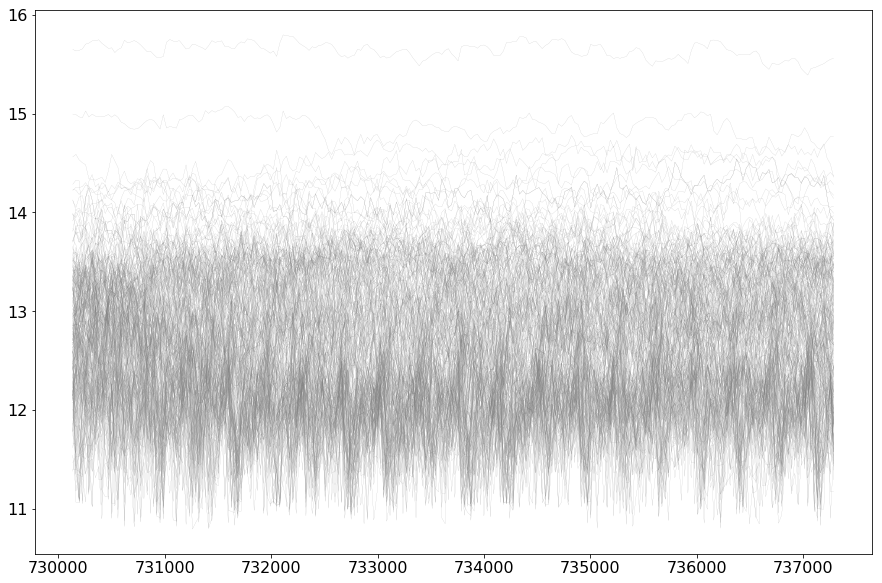

In [120]:
fig, ax = plt.subplots(figsize=(15, 10))

# r, c = np.where(ts_vol_nodata)

# for ii in np.arange(0, np.sum(ts_vol_nodata), 1):
#     ax.plot(ts_vol['time'], ts_vol_norm[r[ii], c[ii], :], color=[0.5, 0.5, 0.5], linewidth=0.1)
    
for ii in np.arange(0, np.shape(ts_vol_norm)[1], 1):
    ax.plot(ts_vol['time'], ts_vol_train[ii, :], color=[0.5, 0.5, 0.5], linewidth=0.1)

# ax.plot(ts_vol['time'], stand.mean_ - stand.scale_, 'k--')
# ax.plot(ts_vol['time'], stand.mean_ + stand.scale_, 'k--')
# ax.plot(ts_vol['time'], stand.mean_, color='k')

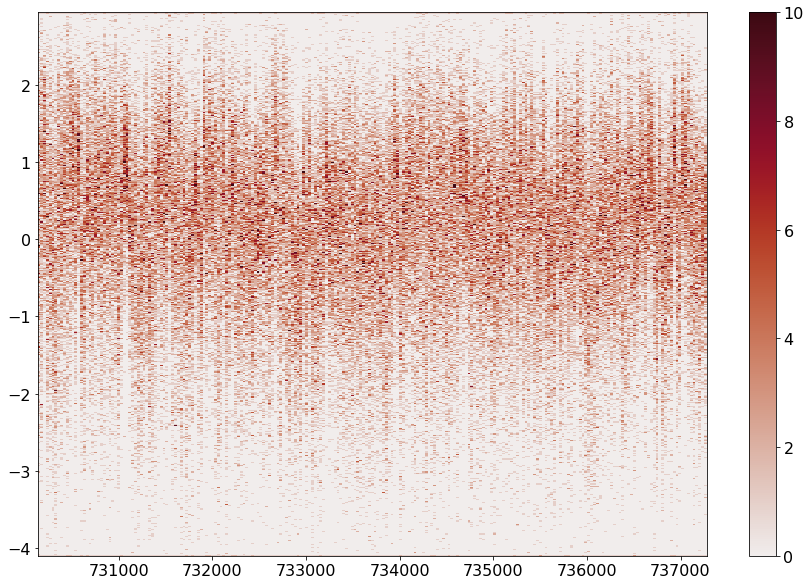

In [98]:
fig, ax = plt.subplots(figsize=(15,10))
c_lim = (0, 10)
cs = ax.pcolormesh(ts_vol['time'], amon_bin_mid, (ts_vol_pdf_t), cmap=cmocean.cm.amp, vmin=c_lim[0], vmax=c_lim[1])
# ax.set_yscale('log')
# ax.set_ylim(1e-2, 1e16)
cbar = fig.colorbar(cs)

In [112]:
# datvec = np.zeros((len(ts_vol['time']), 3))
# for ii in np.arange(0, len(ts_vol['time']), 1):
#     datvec[ii, 0] = mdates.num2date(ts_vol['time'])[ii].year
#     datvec[ii, 1] = mdates.num2date(ts_vol['time'])[ii].month
#     datvec[ii, 2] = mdates.num2date(ts_vol['time'])[ii].day
    

# fig = plt.figure(figsize=(20, 20))
# ax = fig.subplots(4, 3)

# ts_vol_pdf_t_mm = np.zeros((np.shape(ts_vol_pdf_t)[0], 12))
# # G_t_mm_an = np.zeros(np.shape(G_t))
# ax_lim = (0, 5)

# for ii in np.arange(1, 13, 1):
#     ts_vol_pdf_t_mm[:, ii - 1] = np.nanmean(ts_vol_pdf_t[:, datvec[:, 1] == ii], axis=1)
    
#     ax.flatten('c')[ii - 1].bar(amon_bin_mid[1:-1], (ts_vol_pdf_t_mm[1:, ii - 1]), edgecolor='none', width=0.05)
#     ax.flatten('c')[ii - 1].set_title('{:2.0f}'.format(ii))
#     ax.flatten('c')[ii - 1].set_ylim(ax_lim)

### Now run GMM on the training dataset

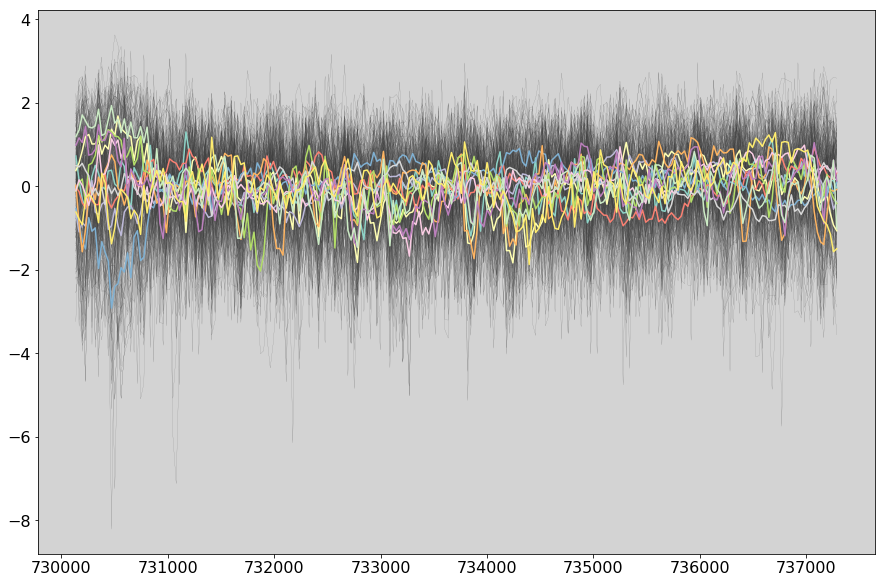

In [121]:
cov_type = 'full'  # covariance type (full, tied, diag, or spherical)
n_comp = 12 # number of classes in GMM object

gmm = None
gmm = mixture.GaussianMixture(n_components = n_comp, \
                                  covariance_type = cov_type)

gmm.fit(ts_vol_norm)

weights = np.squeeze(gmm.weights_)  # shape (n_components)
# note: "weights" is the same for each col_red
means = np.squeeze(gmm.means_)  # shape (n_components, n_features)
covariances = abs(np.squeeze(gmm.covariances_))  # shape (n_components, n_features) 

fig, ax = plt.subplots(figsize=(15, 10))
    
for ii in np.arange(0, np.shape(ts_vol_norm)[1], 1):
    ax.plot(ts_vol['time'], ts_vol_norm[ii, :], color=[0.25, 0.25, 0.25], linewidth=0.1)

plot_col = ('#8dd3c7',
    '#ffffb3',
    '#bebada',
    '#fb8072',
    '#80b1d3',
    '#fdb462',
    '#b3de69',
    '#fccde5',
    '#d9d9d9',
    '#bc80bd',
    '#ccebc5',
    '#ffed6f',
    '#b15928',
    '#33a02c')

for ii in np.arange(0, n_comp, 1):
    ax.plot(ts_vol['time'], means[ii, :], color=plot_col[ii])

ax.set_facecolor('lightgray')

### Label the TS-Classes

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


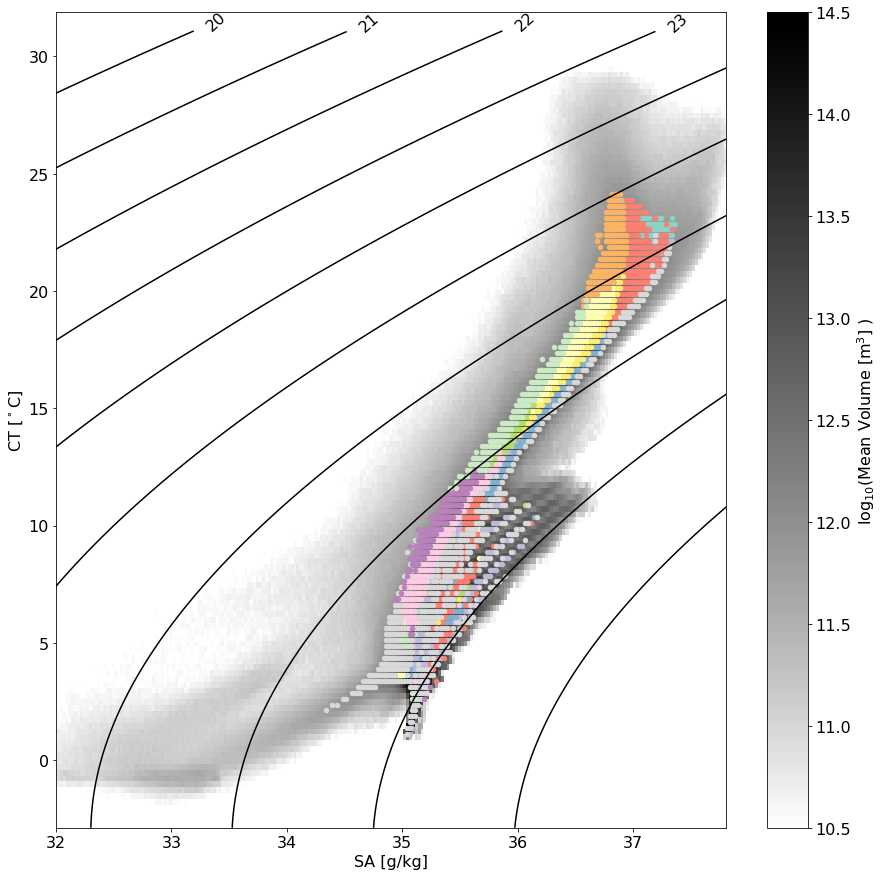

In [122]:
labels = gmm.predict(ts_vol_norm_full)
post_prob = gmm.predict_proba(ts_vol_norm_full)

post_prob_class = np.nanmax(post_prob, axis=1)

S_g, T_g = np.meshgrid(S_bini, T_bini)
S_label_index = S_g[ts_vol_nodata]
T_label_index = T_g[ts_vol_nodata]

c_lim = (10.5, 14.5)
levels = np.arange(c_lim[0], c_lim[1] + 0.1, 0.1)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.subplots()

CS1 = ax1.pcolormesh(S_bini, T_bini, np.log10(np.nanmean(ts_vol_zero, axis=2) ),  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
CS_dens = ax1.contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
ax1.clabel(CS_dens, fmt='%2.0f')

cbar = fig.colorbar(CS1, ax=ax1)
cbar.ax.set_ylabel('log$_{10}$(Mean Volume [m$^3$] )')

ax1.set_ylabel('CT [$^\circ$C]')

ax1.set_xlabel('SA [g/kg]')

ax1.set_xlim((32, 37.8))

for ii in np.unique(labels):
    ax1.scatter(S_label_index[labels == ii], T_label_index[labels == ii], s = 20, c = plot_col[ii])

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


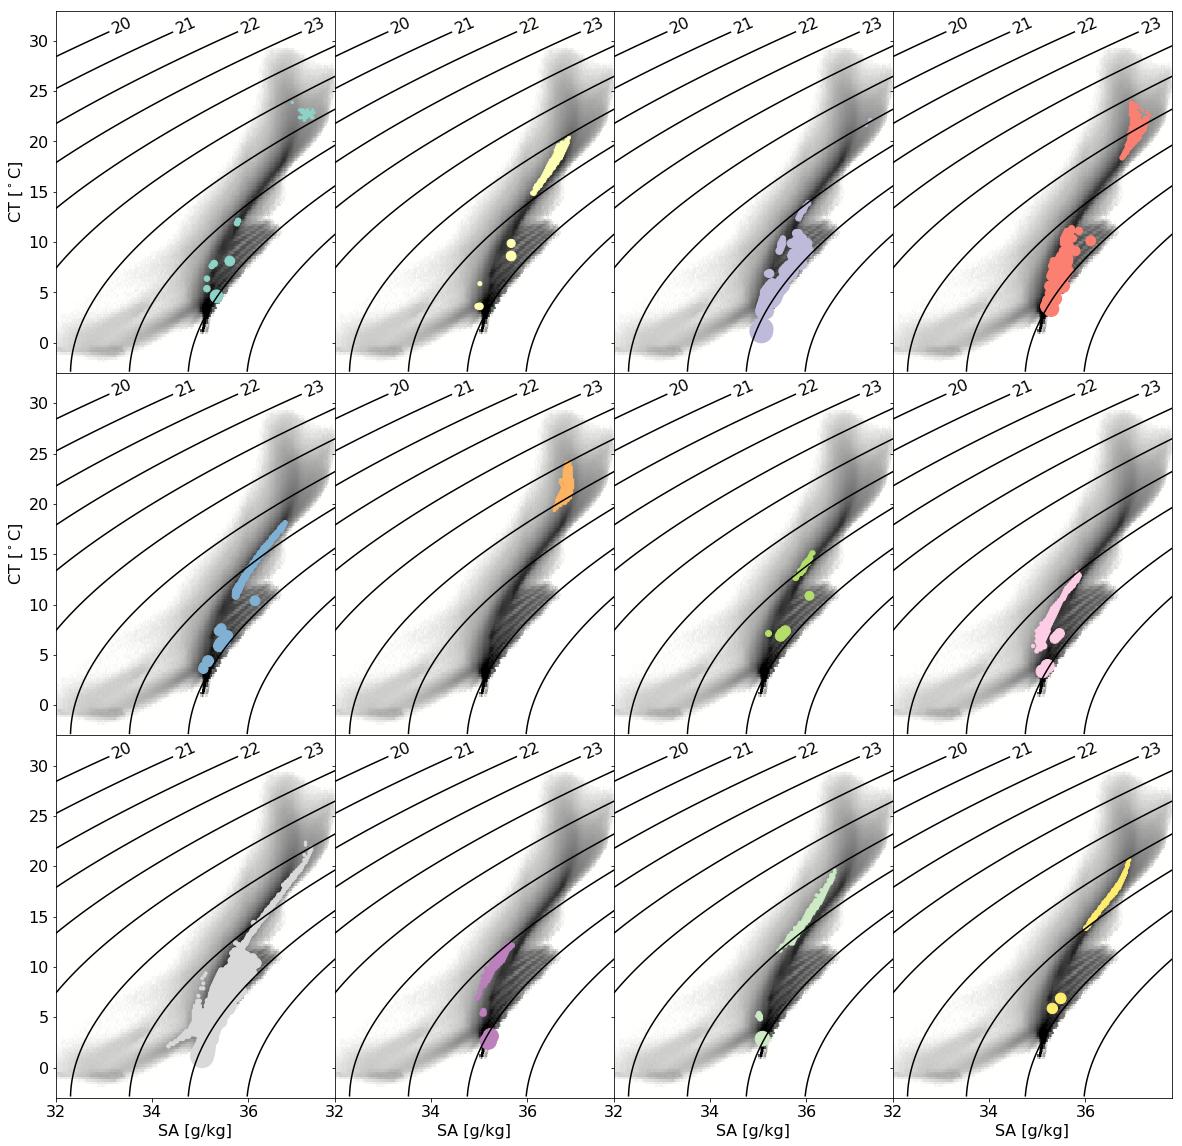

In [123]:
S_g, T_g = np.meshgrid(S_bini, T_bini)
S_label_index = S_g[ts_vol_nodata]
T_label_index = T_g[ts_vol_nodata]

ts_dep_flat = np.nanmean(ts_dep, axis=2)[ts_vol_nodata]

c_lim = (10.5, 14.5)
levels = np.arange(c_lim[0], c_lim[1] + 0.1, 0.1)
fig = plt.figure(figsize=(20, 20))

ax = fig.subplots(3, 4, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0})

for ii in np.arange(0, n_comp, 1):

    ax.flatten()[ii].set_xlim((32, 37.8))
    ax.flatten()[ii].set_ylim((-3, 33))

    ax.flatten()[ii].pcolormesh(S_bini, T_bini, np.log10(np.nanmean(ts_vol_zero, axis=2) ),  vmin=c_lim[0], vmax=c_lim[1], cmap=cmocean.cm.gray_r, shading='flat')
    CS_dens = ax.flatten()[ii].contour(S_bini, T_bini, dens_g, np.arange(20, 30, 1), colors='k')
    ax.flatten()[ii].clabel(CS_dens, fmt='%2.0f')
    
    if (ii == 0) | (ii == 4):
        ax.flatten()[ii].set_ylabel('CT [$^\circ$C]')

    if ii > 3:
        ax.flatten()[ii].set_xlabel('SA [g/kg]')
    
#     CS1 = ax[ii].scatter(S_label_index[labels == ii], T_label_index[labels == ii], c = post_prob_class[labels == ii], s = 25)
    CS1 = ax.flatten()[ii].scatter(S_label_index[labels == ii], T_label_index[labels == ii], c = plot_col[ii], s = ts_dep_flat[labels == ii]/10)
#     cbar = fig.colorbar(CS1, ax=ax[ii])
    cbar.ax.set_ylabel('Probability')
    
plt.savefig(os.path.expanduser('~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/EN4_RAPID2OSNAP_ts_classes.png'), dpi=300, bbox_inches='tight')


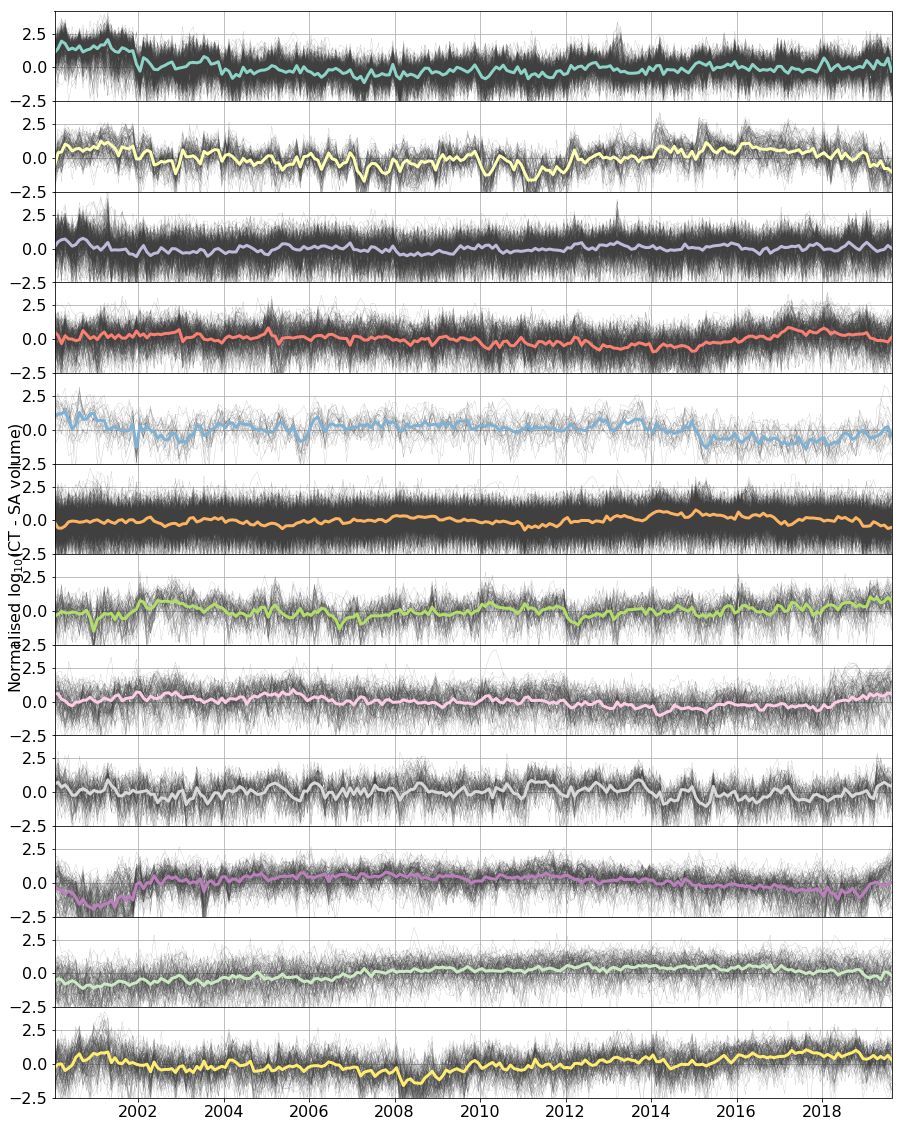

In [95]:
fig = plt.figure(figsize=(15, 20))
ax = fig.subplots(n_comp, 1, sharex='col', gridspec_kw={'hspace': 0})

fig.text(0.09, 0.5, 'Normalised log$_{10}$(CT - SA volume)', ha='center', va='center', rotation='vertical')

for ii in np.arange(0, n_comp, 1):
    
    dat_ind = np.nonzero(labels == ii)[0]
    
    for jj in np.arange(0, len(dat_ind), 1):
        
        ax[ii].plot(ts_vol['time'], ts_vol_norm_full[dat_ind[jj], :], color=[0.25, 0.25, 0.25], linewidth=0.1)
    
    ax[ii].plot(ts_vol['time'], means[ii, :], color=plot_col[ii], linewidth=3)
#     ax[ii].set_facecolor('lightgray')
    
    loc = mdates.AutoDateLocator()
    tick_format = mdates.AutoDateFormatter(loc)
    ax[ii].xaxis.set_major_locator(loc)
    ax[ii].xaxis.set_major_formatter(tick_format)
    
    ax[ii].set_xlim((np.min(ts_vol['time']), np.max(ts_vol['time'])))
    ax[ii].set_ylim((-2.5, 4.2))
    ax[ii].grid(True)

plt.savefig(os.path.expanduser('~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/EN4_RAPID2OSNAP_ts_class_timeseries.png'), dpi=300, bbox_inches='tight')


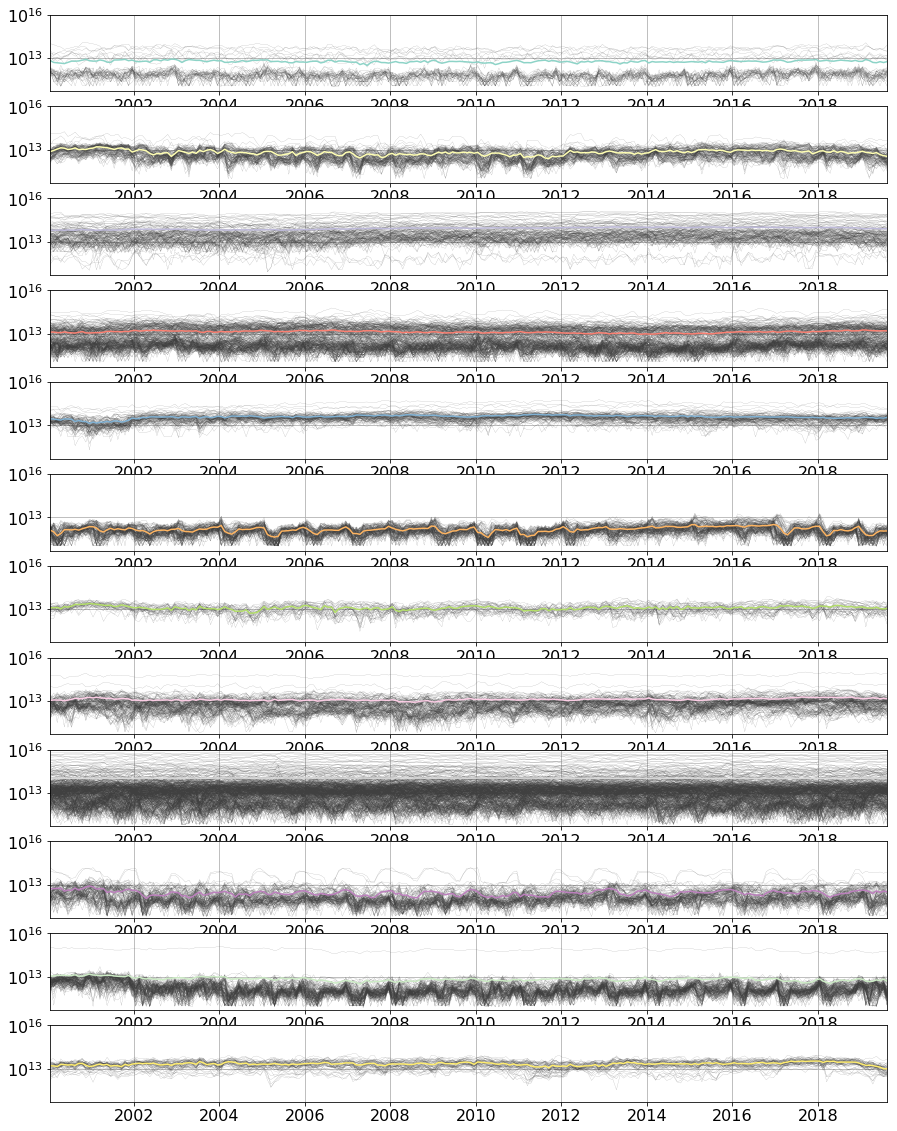

In [124]:
fig = plt.figure(figsize=(15, 20))
ax = fig.subplots(n_comp, 1)

for ii in np.arange(0, n_comp, 1):
    
    dat_ind = np.nonzero(labels == ii)[0]
    class_vol = np.zeros((len(dat_ind), len(ts_vol['time'])))
    
    for jj in np.arange(0, len(dat_ind), 1):
        
        class_vol[jj, :] = ts_vol_flat_no0[dat_ind[jj], :]
        ax[ii].plot(ts_vol['time'], ts_vol_flat_no0[dat_ind[jj], :], color=[0.25, 0.25, 0.25], linewidth=0.1)
        
    ax[ii].semilogy(ts_vol['time'], np.mean(class_vol, axis=0), color=plot_col[ii])
    
    loc = mdates.AutoDateLocator()
    tick_format = mdates.AutoDateFormatter(loc)
    ax[ii].xaxis.set_major_locator(loc)
    ax[ii].xaxis.set_major_formatter(tick_format)
    
    ax[ii].set_xlim((np.min(ts_vol['time']), np.max(ts_vol['time'])))
    ax[ii].set_ylim((5e10, 1e16))
    ax[ii].grid(True)
#     ax[ii].set_facecolor('lightgray')

/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/Users/dgwynevans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


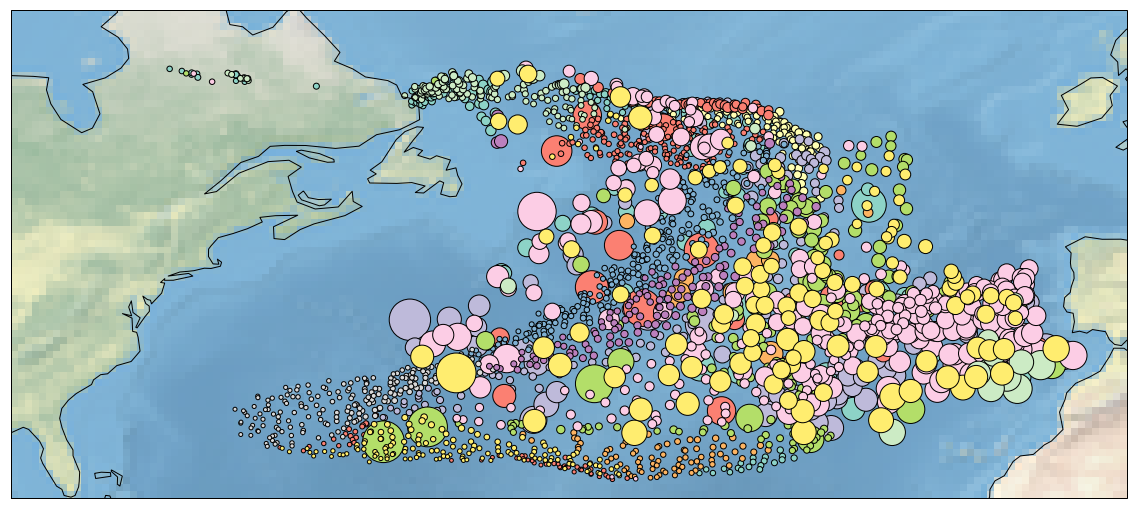

In [50]:
ts_lon_flat = np.nanmean(ts_lon, axis=2)[ts_vol_nodata]
ts_lat_flat = np.nanmean(ts_lat, axis=2)[ts_vol_nodata]
ts_dep_flat = np.nanmean(ts_dep, axis=2)[ts_vol_nodata]

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([lon_limits[0], lon_limits[1], lat_limits[0], lat_limits[1]], crs=ccrs.PlateCarree())
ax1.stock_img()
ax1.coastlines()

for ii in np.unique(labels):
    ax1.scatter(ts_lon_flat[labels == ii], ts_lat_flat[labels == ii], s = ts_dep_flat[labels == ii]/3, c = plot_col[ii], edgecolor='k')

plt.savefig(os.path.expanduser('~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/EN4_RAPID2OSNAP_ts_classes_mean_map.png'), dpi=300, bbox_inches='tight')


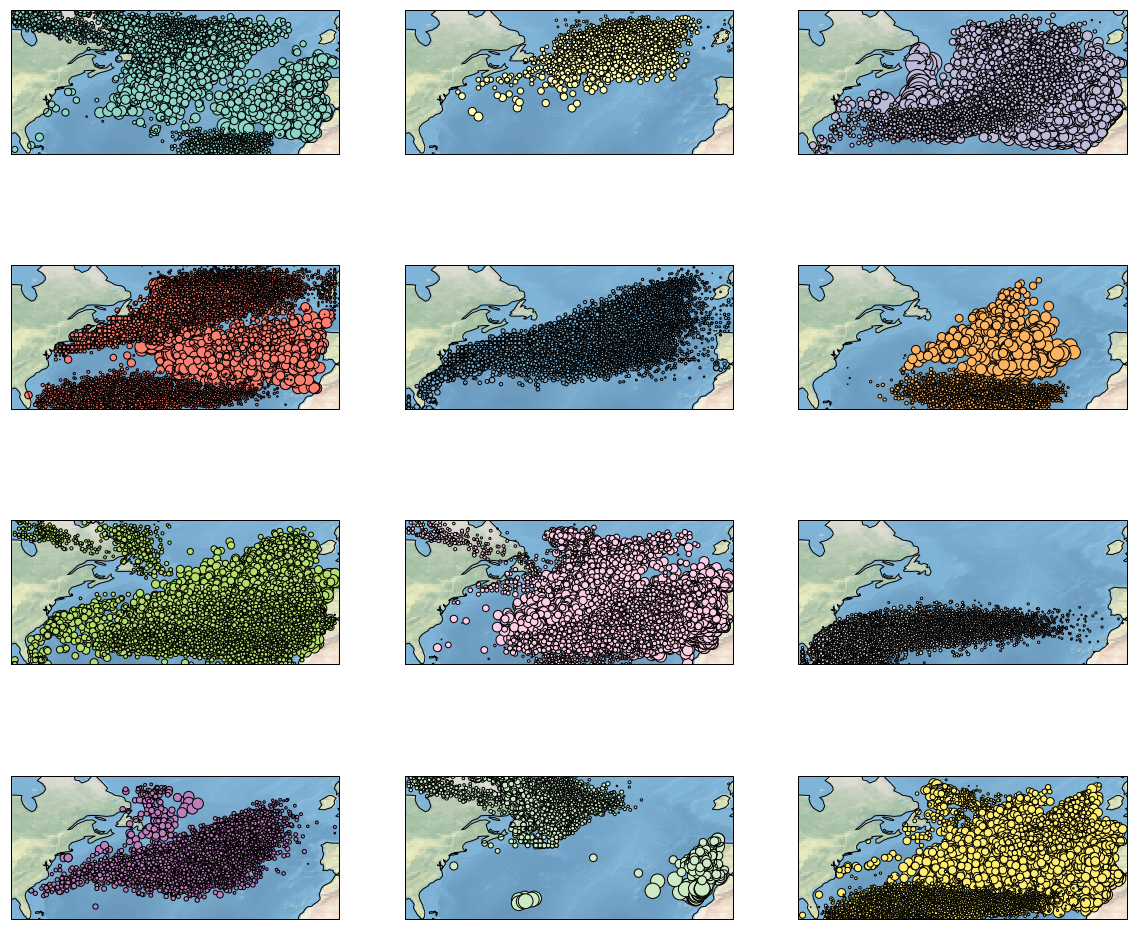

In [52]:
S_g, T_g = np.meshgrid(S_bini, T_bini)
S_label_index = S_g[ts_vol_nodata]
T_label_index = T_g[ts_vol_nodata]

fig = plt.figure(figsize=(20, 18), constrained_layout=False)


# ax = fig.subplots(2, 4, sharex='col', sharey='row',
#                         gridspec_kw={'hspace': 0, 'wspace': 0}, projection=ccrs.PlateCarree())
# ax = fig.add_subplot(2, 4, sharex='col', sharey='row',
#                         gridspec_kw={'hspace': 0, 'wspace': 0}, projection=ccrs.PlateCarree())


for ii in np.arange(0, n_comp, 1):

    ax = fig.add_subplot(4, 3, ii+1, projection=ccrs.PlateCarree())

    ax.set_extent([lon_limits[0], lon_limits[1], lat_limits[0], lat_limits[1]], crs=ccrs.PlateCarree())
    ax.stock_img()
    ax.coastlines()

    class_S = S_label_index[labels == ii]
    class_T = T_label_index[labels== ii]

    for jj in np.arange(0, len(class_S), 4):
    
        ts_idx = np.where((S_g == class_S[jj]) & (T_g == class_T[jj]))
    
        ax.scatter(ts_lon[ts_idx[0], ts_idx[1], :], ts_lat[ts_idx[0], ts_idx[1], :], s = ts_dep[ts_idx[0], ts_idx[1], :]/10, c = plot_col[ii], edgecolor='k')
    

plt.savefig(os.path.expanduser('~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/EN4_RAPID2OSNAP_ts_classes_map.png'), dpi=300, bbox_inches='tight')


In [67]:
fig = plt.figure(figsize=(20, 20))

gs = gridspec.GridSpec(4, 2, width_ratios=[0.8,1],hspace=0.1,wspace=0.1)

gs[0, 1]


<Figure size 1440x1440 with 0 Axes>

Need to give less representation to the low volume stuff and more to the high volume stuff. In other words, select more of the high vol and less of the low vol. Try separating into regions using the quad-tree method from Jan's paper and select a profile from each of these regions for the training dataset

In [135]:
G_t = np.zeros((len(ts_vol['T_bini']) - 1, len(ts_vol['S_bini']), len(ts_vol['time']) ) )
G_ti = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']), len(ts_vol['time']) ) )

G_s = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']) - 1, len(ts_vol['time']) ) )
G_si = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']), len(ts_vol['time']) ) )

dvol = np.zeros((len(ts_vol['T_bini']), len(ts_vol['S_bini']), len(ts_vol['time']) ) )

tot_trans = {'G_t': G_t, 'G_s': G_s, 'G_ti': G_ti, 'G_si': G_si, 'dvol': dvol}

dt = 30 * 24 * 60 * 60

dens_limit = (20, 29.5)
dens_idx = (dens_g < dens_limit[0]) | (dens_g > dens_limit[1])
# ts_vol['ts_vol'][np.repeat(np.expand_dims(dens_idx, axis=2), len(ts_vol['time']), axis=2)] = 0

# ts_vol_plus1 = np.dstack((ts_vol['ts_vol'][: , : , 1:], np.zeros(np.shape(ts_vol['ts_vol'])[:-1])))
# ts_vol_minus1 = np.dstack((np.zeros(np.shape(ts_vol['ts_vol'])[:-1]), ts_vol['ts_vol'][: , : , :-1]))
ts_vol_plus1 = np.dstack((ts_vol_mm_an[: , : , 1:], np.zeros(np.shape(ts_vol_mm_an)[:-1])))
ts_vol_minus1 = np.dstack((np.zeros(np.shape(ts_vol_mm_an)[:-1]), ts_vol_mm_an[: , : , :-1]))

ts_vol_plus1[np.repeat(np.expand_dims(dens_idx, axis=2), len(ts_vol['time']), axis=2)] = 0
ts_vol_minus1[np.repeat(np.expand_dims(dens_idx, axis=2), len(ts_vol['time']), axis=2)] = 0

for ii in np.arange(0, len(ts_vol['time']), 1):

#     ts_vol_start = ts_vol['ts_vol'][:, :, ii]
#     ts_vol_end = ts_vol['ts_vol'][:, :, ii+1]

    ts_vol_start = ts_vol_minus1[:, :, ii]
    ts_vol_end = ts_vol_plus1[:, :, ii]

    out = calc_tot_trans(ts_vol_start, ts_vol_end, dt, ts_vol['S_bini'], ts_vol['T_bini'], ts_vol['S_binii'], ts_vol['T_binii'])

    tot_trans['G_t'][:, :, ii] = out['G_t']
    tot_trans['G_ti'][:, :, ii] = out['G_ti']
    tot_trans['G_s'][:, :, ii] = out['G_s']
    tot_trans['G_si'][:, :, ii] = out['G_si']
    tot_trans['dvol'][:, :, ii] = out['dvol']


### Save using pickle

To load use the following: </br>

```python
with open(fname, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    ts_vol = pickle.load(f)
```

In [144]:
outfile = '/Users/dgwynevans/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/EN4_TS_dS_{:2.2f}_dT_{:2.2f}_dens_lim_{:2.2f}_{:2.2f}_lat_{:2.0f}_{:2.0f}.pickle'.format(dS, dT, dens_limit[0], dens_limit[1], lat_limits[0], lat_limits[1])

with open(outfile, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump((tot_trans, ts_vol), f, pickle.HIGHEST_PROTOCOL)

In [122]:
dens_limit = (20, 29)

outfile = '/Users/dgwynevans/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/EN4_TS_dS_{:2.2f}_dT_{:2.2f}_dens_lim_{:2.2f}_{:2.2f}_lat_{:2.0f}_{:2.0f}.pickle'.format(dS, dT, dens_limit[0], dens_limit[1], lat_limits[0], lat_limits[1])

with open(outfile, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    out = pickle.load(f)

tot_trans = out[0]
ts_vol = out[1]

In [13]:
def dateticker(ax):
    loc = mdates.AutoDateLocator()
    tick_format = mdates.AutoDateFormatter(loc)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(tick_format)

Text(0, 0.5, 'SA [g/kg]')

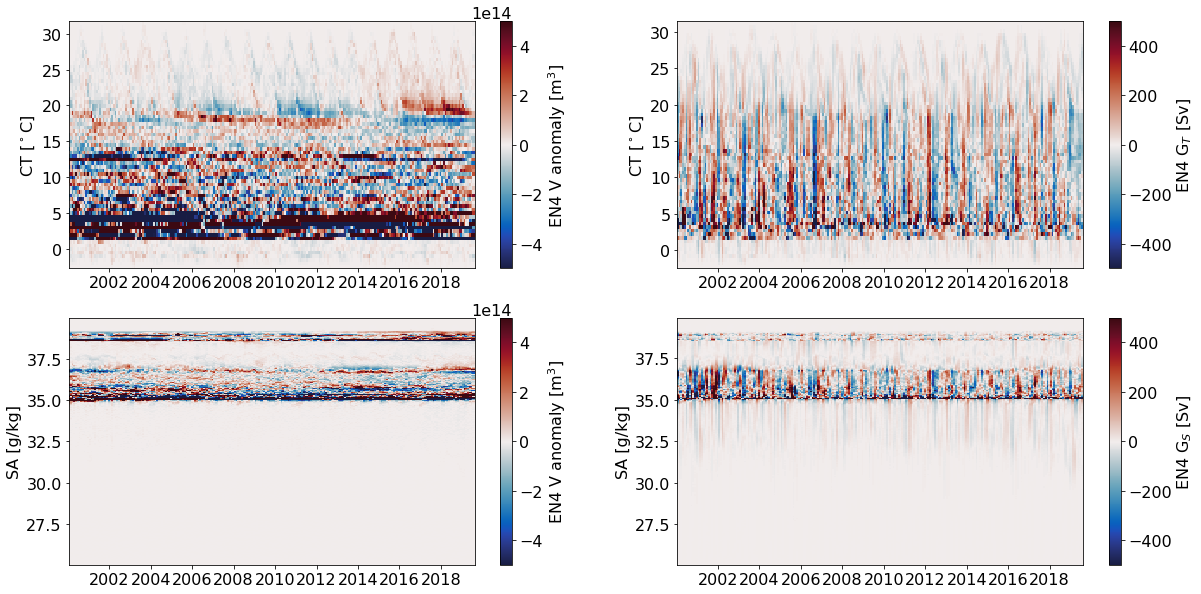

In [136]:
vol_time_anom_t = np.nansum(ts_vol_mm_an, axis=1)
vol_time_anom_s = np.nansum(ts_vol_mm_an, axis=0)

# vol_time_anom_t = np.nansum(ts_vol['ts_vol'] - np.expand_dims(np.nanmean(ts_vol['ts_vol'], axis=2), axis=2), axis=1)
# vol_time_anom_s = np.nansum(ts_vol['ts_vol'] - np.expand_dims(np.nanmean(ts_vol['ts_vol'], axis=2), axis=2), axis=0)

G_t_time_anom_t = np.nansum(tot_trans['G_t'] - np.expand_dims(np.nanmean(tot_trans['G_t'], axis=2), axis=2), axis=1)
G_s_time_anom_s = np.nansum(tot_trans['G_s'] - np.expand_dims(np.nanmean(tot_trans['G_s'], axis=2), axis=2), axis=0)

G_t_t = np.nansum(tot_trans['G_t'], axis=1)
G_s_s = np.nansum(tot_trans['G_s'], axis=0)

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(2, 2)
ax1 = ax[0, 0]
ax2 = ax[1, 0]
ax3 = ax[0, 1]
ax4 = ax[1, 1]

vol_lim = (-5e14, 5e14)
cs_t = ax1.pcolormesh(ts_vol['time'], ts_vol['T_bini'], vol_time_anom_t, vmin=vol_lim[0], vmax=vol_lim[1], cmap=cmocean.cm.balance)
dateticker(ax1)
cs_s = ax2.pcolormesh(ts_vol['time'], ts_vol['S_bini'], vol_time_anom_s, vmin=vol_lim[0], vmax=vol_lim[1], cmap=cmocean.cm.balance)
dateticker(ax2)

cbar = fig.colorbar(cs_t, ax=ax1)
cbar.ax.set_ylabel('EN4 V anomaly [m$^3$]')

cbar = fig.colorbar(cs_s, ax=ax2)
cbar.ax.set_ylabel('EN4 V anomaly [m$^3$]')
ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('SA [g/kg]')

trans_lim = (-500, 500)
cs_t = ax3.pcolormesh(ts_vol['time'], ts_vol['T_binii'], G_t_t / 1e6, vmin=trans_lim[0], vmax=trans_lim[1], cmap=cmocean.cm.balance)
dateticker(ax3)
cs_s = ax4.pcolormesh(ts_vol['time'], ts_vol['S_binii'], G_s_s / 1e6, vmin=trans_lim[0], vmax=trans_lim[1], cmap=cmocean.cm.balance)
dateticker(ax4)

cbar = fig.colorbar(cs_t, ax=ax3)
cbar.ax.set_ylabel('EN4 G$_T$ [Sv]')

cbar = fig.colorbar(cs_s, ax=ax4)
cbar.ax.set_ylabel('EN4 G$_S$ [Sv]')
ax3.set_ylabel('CT [$^\circ$C]')
ax4.set_ylabel('SA [g/kg]')

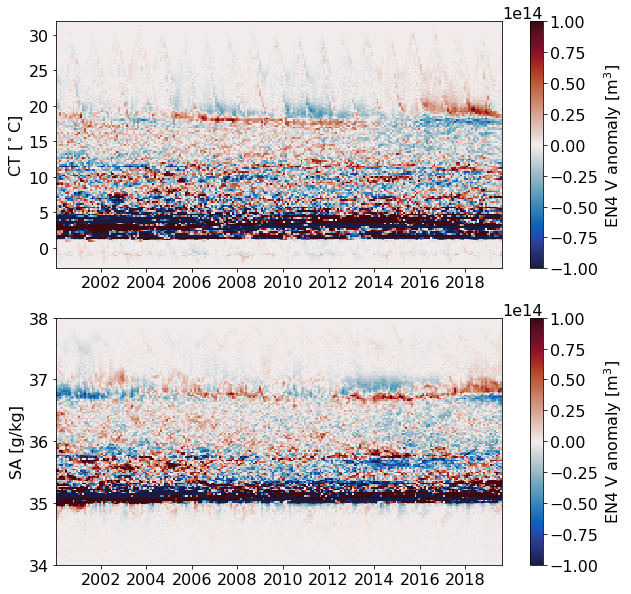

In [23]:
datvec = np.zeros((len(ts_vol['time']), 3))
for ii in np.arange(0, len(ts_vol['time']), 1):
    datvec[ii, 0] = mdates.num2date(ts_vol['time'])[ii].year
    datvec[ii, 1] = mdates.num2date(ts_vol['time'])[ii].month
    datvec[ii, 2] = mdates.num2date(ts_vol['time'])[ii].day

ts_vol_mm, ts_vol_mm_an = calc_mm_an(ts_vol['ts_vol'], datvec)

# vol_time_anom_t = np.nansum(ts_vol['ts_vol'] - np.expand_dims(np.nanmean(ts_vol['ts_vol'], axis=2), axis=2), axis=1)
# vol_time_anom_s = np.nansum(ts_vol['ts_vol'] - np.expand_dims(np.nanmean(ts_vol['ts_vol'], axis=2), axis=2), axis=0)

vol_time_anom_t = np.nansum(ts_vol_mm_an, axis=1)
vol_time_anom_s = np.nansum(ts_vol_mm_an, axis=0)

fig = plt.figure(figsize=(10,10))
ax = fig.subplots(2, 1)
ax1 = ax[0]
ax2 = ax[1]

vol_lim = (-1e14, 1e14)
cs_t = ax1.pcolormesh(ts_vol['time'], ts_vol['T_bini'], vol_time_anom_t, vmin=vol_lim[0], vmax=vol_lim[1], cmap=cmocean.cm.balance)
dateticker(ax1)
cs_s = ax2.pcolormesh(ts_vol['time'], ts_vol['S_bini'], vol_time_anom_s, vmin=vol_lim[0], vmax=vol_lim[1], cmap=cmocean.cm.balance)
dateticker(ax2)

cbar = fig.colorbar(cs_t, ax=ax1)
cbar.ax.set_ylabel('EN4 V anomaly [m$^3$]')

cbar = fig.colorbar(cs_s, ax=ax2)
cbar.ax.set_ylabel('EN4 V anomaly [m$^3$]')

ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('SA [g/kg]')

ax2.set_ylim((34, 38))

plt.savefig(os.path.expanduser('~/Dropbox/work_general/projects/CLASS/RAPID2OSNAP/analysis/figs/EN4_RAPID2OSNAP_T_vol_anomaly.png'), dpi=300, bbox_inches='tight')


In [82]:
datvec = np.zeros((len(ts_vol['time']), 3))
for ii in np.arange(0, len(ts_vol['time']), 1):
    datvec[ii, 0] = mdates.num2date(ts_vol['time'])[ii].year
    datvec[ii, 1] = mdates.num2date(ts_vol['time'])[ii].month
    datvec[ii, 2] = mdates.num2date(ts_vol['time'])[ii].day
    
G_t = tot_trans['G_t'][: , :, 1:-1]
G_s = tot_trans['G_s'][: , :, 1:-1]

G_t_mm = np.zeros((np.shape(tot_trans['G_t'])[0], np.shape(tot_trans['G_t'])[1], 12))
G_s_mm = np.zeros((np.shape(tot_trans['G_s'])[0], np.shape(tot_trans['G_s'])[1], 12))
G_t_mm_an = np.zeros(np.shape(G_t))
G_s_mm_an = np.zeros(np.shape(G_s))

for ii in np.arange(1, 13, 1):
    G_t_mm[:, :, ii - 1] = np.nanmean(G_t[:, :, datvec[1:-1, 1] == ii], axis=2)
    G_s_mm[:, :, ii - 1] = np.nanmean(G_s[:, :, datvec[1:-1, 1] == ii], axis=2)
    
    G_t_mm_an[:, :, datvec[1:-1, 1] == ii] = G_t[:, :, datvec[1:-1, 1] == ii] - np.expand_dims(G_t_mm[:, :, ii - 1], axis=2)    
    G_s_mm_an[:, :, datvec[1:-1, 1] == ii] = G_s[:, :, datvec[1:-1, 1] == ii] - np.expand_dims(G_s_mm[:, :, ii - 1], axis=2)

Text(0, 0.5, 'SA [g/kg]')

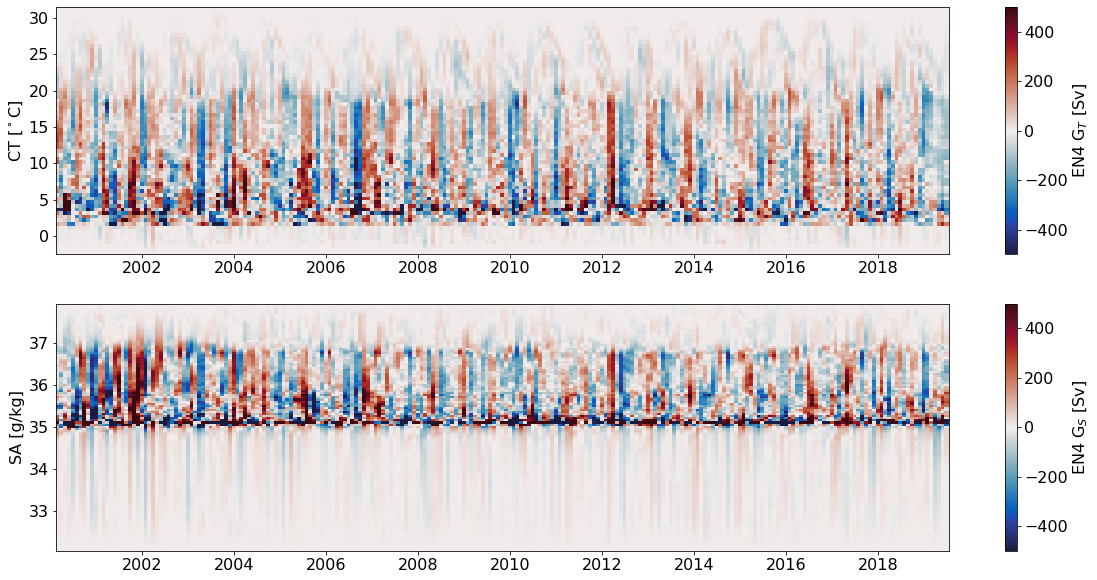

In [84]:
G_t_mm_an_t = np.nansum(G_t_mm_an, axis=1)
G_s_mm_an_s = np.nansum(G_s_mm_an, axis=0)

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(2, 1)
ax1 = ax[0]
ax2 = ax[1]


trans_lim = (-500, 500)
cs_t = ax1.pcolormesh(ts_vol['time'][1:-1], ts_vol['T_binii'], G_t_mm_an_t / 1e6, vmin=trans_lim[0], vmax=trans_lim[1], cmap=cmocean.cm.balance)
dateticker(ax1)
cs_s = ax2.pcolormesh(ts_vol['time'][1:-1], ts_vol['S_binii'], G_s_mm_an_s / 1e6, vmin=trans_lim[0], vmax=trans_lim[1], cmap=cmocean.cm.balance)
dateticker(ax2)

cbar = fig.colorbar(cs_t, ax=ax1)
cbar.ax.set_ylabel('EN4 G$_T$ [Sv]')

cbar = fig.colorbar(cs_s, ax=ax2)
cbar.ax.set_ylabel('EN4 G$_S$ [Sv]')
ax1.set_ylabel('CT [$^\circ$C]')
ax2.set_ylabel('SA [g/kg]')